# Zadanie 1

## Przygotowywania do zadania 

### Wczytywanie potrzebnych bibliotek

In [19]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import math

### Ustawianie globalnych danych

Ustawiam tutaj, dane które są uniwersalne dla każdego testu, to znaczy:

1. Liczba stopni swobody
2. Liczba danych
3. Liczba symulacji, które wykonam
4. Poziom istnotności


In [20]:
np.random.seed(seed=123)

# Zakres stopni swobody, jakie zaprezentuję na wykresie
stopnie_swobody = range(1, 50, 1)  # Zakres od 1-50 co 1
# Ustalam poziom istotności
poziom_istotnosci = 0.05
# Liczba danych dla jakich wykonam symulacje
liczby_danych = [10, 20, 50, 100, 200]
# Liczba symulacji na jakich będę bazować
liczba_symulacji = 2500

## Badanie 

### Potrzebne funkcje 

Tutaj stworzę wszystkie funkcje, które wykorzystam do badania, przy okazji opisując od razu ich działanie. Następnie przy symulacji badania, będą one tylko wywoływane. Funkcje zaczynają się od najbardziej ogólnej i idą w dół razem z programem(idziemy po kolei tak samo jak program).

#### Funkcja obliczania mocy testu 

Najogólniejsza funkcja, która przygotuje dane, które wykorzystam, aby zrobić symulacje w funkcji symulacja. Więc ustalamy liczbę danych oraz stopień swobody i idziemy dalej przekazując parametry dalej do funkcji. Po symulacji dodajemy wynik do tablicy i idziemy dalej. Od razu wybieram czy to będzie klasyczny sposób testowania czy z wykorzystaniem PIT. 

Argumenty: 
- test - Mówi który test jest symulowany
- PIT - Czy testujemy z wykorzystaniem PIT

Funkcja będzie zwracać tablice 2D(i,j), która zbierała dane dla i-tej liczbie danych oraz j-tych stopni swobody.



In [21]:
def obliczanie_mocy_testu(test,PIT):
    # Tablica, która zbierze mi moce testów, które zwróci
    moce_testow = []

    # Dla każdej liczby z liczby_danych
    for l_danych in liczby_danych:
        """
        Tworzę nową tablicę która przechowuję wyniki mocu testu dla i-tej liczby danych. Lista przechowuje wyniki dla każdego j-stopnia
        swoobody w stopnie_swobody. Wykorzystuje List Comprahension, żeby umilic kod
        """
        moce_testow.append([symulacja(l_danych,s_stopien,test,PIT) for s_stopien in stopnie_swobody])



    # Zwracam w.w tablice
    return moce_testow

#### Funkcja symulacji 

Ustaliliśmy już liczbę danych oraz liczbe stopni swobody dla naszych danych. 
W tej funkcji będziemy generować dane z rozkładu t-studenta dokładnie z tymi parametrami, przekazanymi jako argumenty. 
Następnie prześlemy je do funkcji, która wybierze, który test jest obecnie symulowany i wynik tej funkcji będziemy sumować w zmiennej 
suma_odrzucen_H0.

Argumenty:
- l_danych - Ile danych będziemy losować z rozkładu t-studenta 
- s_stopien - Liczba stopni swobody dla rozkładu t-studenta
- test - Jaki test jest obecnie symulowany
- PIT - Czy testujemy z wykorzystaniem PIT

Funkcja będzie zwracać odsetek w jakim odrzuciłem hipotezę zerową dla podanych parametrów

In [22]:
def symulacja(l_danych,s_stopien,test,PIT):
    # W tej zmiennej będę sumował ile razy odrzuciłem hipotezę zerową dla danego zestawu 
    suma_odrzucenia_H0 = 0

    # Tutaj będzie symulacja
    for k in range(liczba_symulacji):
        # Tworzę próbkę danych z rozkładu t-Studenta o l_danych wielkości oraz s_stopien stopni swobody
        probka = stats.chi2.rvs(s_stopien,size=l_danych)

        # Następnie przekazuje wszystkie dane, aby wybrac który test jest symulowany i dowiedzieć się jaki jest wynik testu
        suma_odrzucenia_H0 += wybor_testu(probka,test,s_stopien,PIT)

    # Zwracam odsetek odrzucenia hipotezy zerowej
    return suma_odrzucenia_H0/liczba_symulacji

#### Funkcja wyboru testu 

Funkcja za argumenty przyjmuje wszystkie dane, które są jej potrzebne do wybrania oraz przeprowadzenia danego testu. 
Argumenty, to:
- test - Jaki test ma zostać wykonany
- probka - Zestandaryzowany zestaw danych, które będziemy badać

Funkcja będzie zwracać 1 lub 0 w zależności od wyniku testu(1-odrzucamy test, 0-nie ma podstaw)

In [23]:
def wartosci_dla_chi2(probka,s_stopien,PIT):
    """
    Jest to funkcja która zwróci 2 zbiory: zbior zaobserwowanych wartosci(na podstawie probki przekazanej do 
    funkcji) oraz zbior wartosci oczekiwanych potrzebnych do testu Chi kwadrat. Zaczne od wylosowania probki 
    z rozkładu chi2 z parametrami takimy jakimi standaryzowałem oryginalna probke. Nastepnie podziele je 
    na przedzialy zawierajce czestotliwosci wystepowania dane. Na koniec wyrównam róznice w sumie tych tablic,
    aby uniknac pozniejszych bledow. Od tego jaka probke będe losowal czy z rozkladu X czy z jednostajnego zalezy 
    od parametru PIT(sposobu testowania)    
    """
    # Losuje probke z rozkladu chi2/jednostajnego o parametrach z proby
    if PIT:
        probka_chi2_or = stats.uniform.rvs(size = len(probka))
    else:
        probka_chi2_or = stats.chi2.rvs(size = len(probka),df = s_stopien)

    # Dzielenie danych na przedzialy
    probka_chi2_or, przedzialy = np.histogram(probka_chi2_or,bins='auto')
    
    # Teraz tam gdzie przedzial ma czestotliwosc 0(co prowadzi do wysypania sie testu chi kwadrat) łącze zewnetrzne
    # przedzialy w jedno
    indexes = np.nonzero(probka_chi2_or==0)[0]
    probka_chi2_or = probka_chi2_or[probka_chi2_or != 0]
    przedzialy = np.delete(przedzialy,indexes)

    #Teraz dziele na przedzialy probke pochodzaca z chi2 oryginalnej
    probka, _ = np.histogram(probka,bins=przedzialy)

    # Teraz wyrownuje roznice w sumach tych tablic dajac obserwacje ktore sie nie zmiescily w tym zasiego do ostatnich 
    # przedzialow 
    roznica = sum(probka_chi2_or) - sum(probka)
    probka[0] += math.ceil(roznica/2)
    probka[-1] += math.floor(roznica/2)
    
    # Zwracam tablice gotowe do testu
    return probka,probka_chi2_or


def wybor_testu(probka,test,s_stopien,PIT):

    """
    Ogólna zasada działania testów:
    
    Jezali PIT jest true to wykorzystujemy je do testowania co znaczy ze przeksztalcamy probke na Fx(x)
    i porownujemy ja z rozkladem jednostajnym. Jezeli nie to mamy do czynienia z klasycznym sposobem 
    testowania i postepujemy normalnie.

    Jeżeli pvalue z danego testu jest mniejsze niż wczesniej ustalony poziom istotnotnosci to odrucamy 
    Hipoteze zerowa co znaczy ze zwracamy wartość 1. W przeciwnym wypadku zwracamy 0
    
    """

    # Najpierw podejmiemy wybór jaki test mamy wykonać

    # Test Kolgomorova
    if test == "kol":
        pval = None
        # Proceudra PIT
        if PIT:
            # Zamiana na Fx(x)
            probka = stats.chi2.cdf(probka,df=s_stopien)
            # Uzyskanie pvalue
            pval = stats.kstest(probka,'uniform').pvalue

        # Normalny sposob testowania  
        else:
            pval = stats.kstest(probka,'chi2',args=(s_stopien,)).pvalue

        # Po uzyskaniu pvalue sprawdzam wartosc 
        if pval <0.05: return 1        

    # Test Chi kwadrat
    elif test == "chi":
        pval = None
        # Proceudra PIT
        if PIT:
            # Zamiana na Fx(x)
            probka = stats.chi2.cdf(probka,df=s_stopien)
            # Uzyskanie wartosci oczekiwanych
            fobs,fexp = wartosci_dla_chi2(probka,s_stopien,PIT)
            # Uzyskanie pvalue
            pval = stats.chisquare(fobs,f_exp=fexp).pvalue

        # Normalny sposob testowania  
        else:
             # Uzyskanie wartosci oczekiwanych
            fobs,fexp = wartosci_dla_chi2(probka,s_stopien,PIT)
            # Uzyskanie pvalue
            pval = stats.chisquare(fobs,f_exp=fexp).pvalue

        # Po uzyskaniu pvalue sprawdzam wartosc 
        if pval <0.05: return 1    
    
    # Jeżeli do tej pory nie zwrócono 1 to znaczy, że żaden z testów nie odrzucił H0 więc możemy zwrócic 0
    return 0
            


## Symulacje 

### Klasyczny sposób testowanaia

In [24]:
moc_kolgom = obliczanie_mocy_testu("kol",False)
moc_chi = obliczanie_mocy_testu("chi",False)


### Testowanie z wykorzystaniem PIT

In [25]:
moc_kolgom_pit = obliczanie_mocy_testu("kol",True)
moc_chi_pit = obliczanie_mocy_testu("chi",True)


## Wnioski 

### Test Kołgomorowa

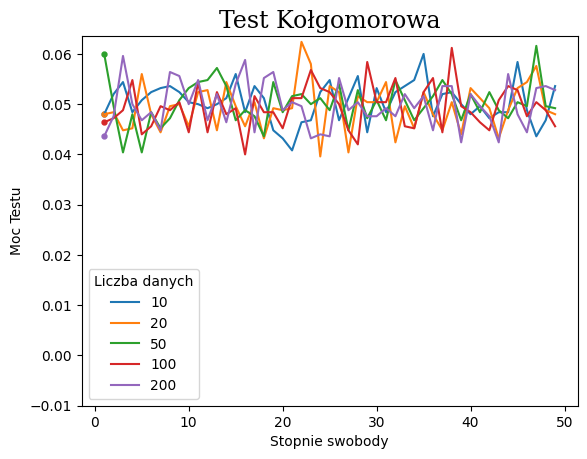

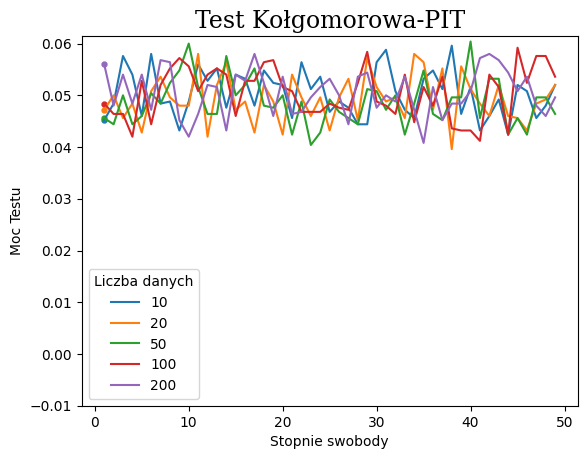

In [30]:

# Tworzę wykres
font_title = {'family' :'serif','size':17}
wykres_kolgo = plt.figure()

# Dodaje dane do wykres
for i,moc in enumerate(moc_kolgom):
    plt.plot(stopnie_swobody,moc,label= str(liczby_danych[i]))
    plt.scatter(stopnie_swobody[0], moc[0], s=50, marker='.') 



# Dodaje opisy do wykresu 
plt.xlabel("Stopnie swobody")
plt.ylabel("Moc Testu")
plt.title("Test Kołgomorowa",fontdict=font_title)
plt.legend(title="Liczba danych")
plt.ylim(-0.01)
plt.show()

# Wykres dla testowania z wykorzystaniem PIT

wykres_kolgo_pit = plt.figure()

# Dodaje dane do wykres
for i,moc in enumerate(moc_kolgom_pit):
    plt.plot(stopnie_swobody,moc,label= str(liczby_danych[i]))
    plt.scatter(stopnie_swobody[0], moc[0], s=50, marker='.') 



# Dodaje opisy do wykresu 
plt.xlabel("Stopnie swobody")
plt.ylabel("Moc Testu")
plt.title("Test Kołgomorowa-PIT",fontdict=font_title)
plt.legend(title="Liczba danych")
plt.ylim(-0.01)
plt.show()


### Wnioski

Wraz ze wzrostem liczby danych wzrasta także moc testu, aczkolwiek wraz ze wzrostem stopni liczby swobody w rozkładzie t-studenta moc testu spada i dąży do 0. Z wykresu widzimy, że moc testu maleje bardzo szybko i już dla 10 stopni swobody jest bliski 0. Wydaje się, że test jest miarodajny i w miarę wiarygodny tylko dla:
- dużej liczby stopni swobody(powyżej 100)
- małej liczby stopni swobody, ale dużej liczbie danych(powyżej 50)

Wynika to z faktu, że Test Kołgomorowa, jest bardziej ogólny niż test Shapiro-Wilka.

### Test chi-kwadrat

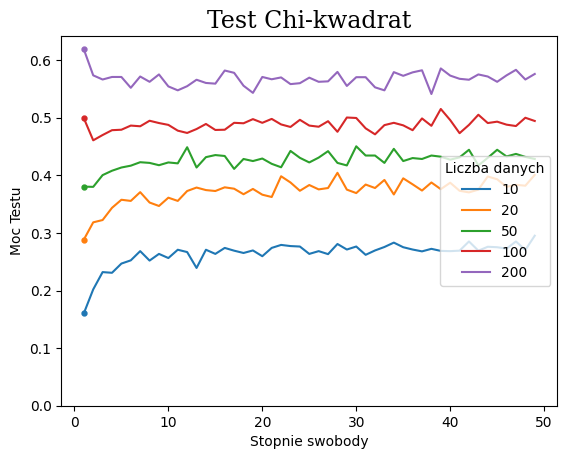

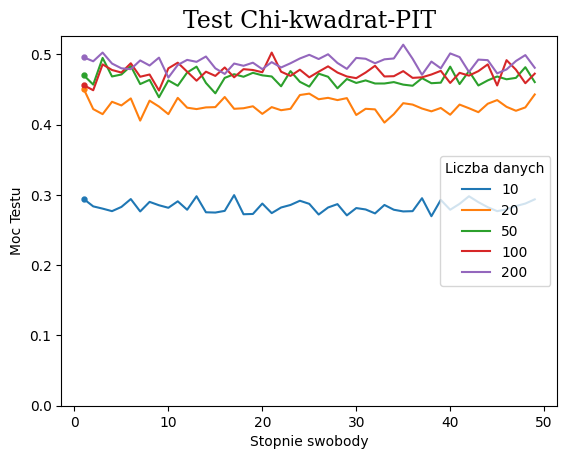

In [31]:

# Tworzę wykres

wykres_chi = plt.figure()

# Dodaje dane do wykresu
for i,moc in enumerate(moc_chi):
    plt.plot(stopnie_swobody,moc,label= str(liczby_danych[i]))
    plt.scatter(stopnie_swobody[0], moc[0], s=50, marker='.') 

# Dodaje opisy do wykresu 
plt.xlabel("Stopnie swobody")
plt.ylabel("Moc Testu")
plt.title("Test Chi-kwadrat",fontdict=font_title)
plt.legend(title="Liczba danych",loc="center right")
plt.ylim(0,)
plt.show()

# Wykres dla testowania z wykorzystaniem PIT
wykres_chi_pit = plt.figure()

# Dodaje dane do wykresu
for i,moc in enumerate(moc_chi_pit):
    plt.plot(stopnie_swobody,moc,label= str(liczby_danych[i]))
    plt.scatter(stopnie_swobody[0], moc[0], s=50, marker='.') 

# Dodaje opisy do wykresu 
plt.xlabel("Stopnie swobody")
plt.ylabel("Moc Testu")
plt.title("Test Chi-kwadrat-PIT",fontdict=font_title)
plt.legend(title="Liczba danych",loc="center right")
plt.ylim(0,)
plt.show()


#### Wnioski

Z wykresu możemy zobaczyć, że moc testu chi kwadrat zgodnie z oczekwaniami maleje wraz ze wzrostem stopni swobody oraz rośnie ze wzrostem liczby danych. Aczkolwiek warto zauważyć, że po pierwsze maleje ale nie tak jak pozostałe testy do wartości bliskiej poziomowi istotności(co jest czymś czego byśmy oczekiwali), tylko  

## Porównanie 
Wyliczę średnią moc każdego z testów dla każdego stopnia swobody, co pomoże pokazać mi różnice.


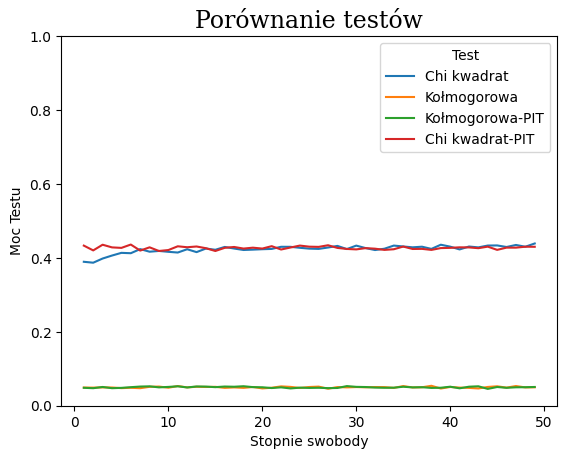

In [37]:
# Tworzenie tablic w których będę trzymał średnie 
srednia_moc_chi = np.zeros(len(stopnie_swobody))
srednia_moc_kol = np.zeros(len(stopnie_swobody))
srednia_moc_chi_pit = np.zeros(len(stopnie_swobody))
srednia_moc_kol_pit = np.zeros(len(stopnie_swobody))


# Sumowanie mocy 
for i in range(len(moc_chi)):
    srednia_moc_chi += moc_chi[i]
    srednia_moc_kol += moc_kolgom[i]
    srednia_moc_chi_pit += moc_chi_pit[i]
    srednia_moc_kol_pit += moc_kolgom_pit[i]


# Wyliczanie średnia 
srednia_moc_chi /= len(moc_chi)
srednia_moc_kol /= len(moc_kolgom)
srednia_moc_chi_pit /= len(moc_kolgom_pit)
srednia_moc_kol_pit /= len(moc_chi_pit)


# Tworzenie wykresu 
w = plt.figure()
plt.plot(stopnie_swobody,srednia_moc_chi,label = "Chi kwadrat")
plt.plot(stopnie_swobody,srednia_moc_kol,label="Kołmogorowa")
plt.plot(stopnie_swobody,srednia_moc_kol_pit,label="Kołmogorowa-PIT")
plt.plot(stopnie_swobody,srednia_moc_chi_pit,label="Chi kwadrat-PIT")
plt.ylim(0,1)
plt.xlabel("Stopnie swobody")
plt.ylabel("Moc Testu")
plt.title("Porównanie testów",fontdict=font_title)
plt.legend(title="Test")
plt.ylim(0,)
plt.show()

### Wnioski
Jak widzimy na wykresie test Shapiro-Wilka jest najbardziej monotonicznym testem w tym zestawie. Natomiast test Kołmogorowa idzie w jedną skrajność, jaką jest bardzo szybki spadek i dążenie do 0. Test Chi kwadrat popada w drugą skrajność jaka jest bardzo wolny spadek, a wręcz asymptotyczne dążenie do niewyjaśnialnej wartości odbiegającej od 0.